# Instal & Upgrade Libary

In [2]:
pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

2024-06-17 05:57:26.550339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 05:57:26.550477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 05:57:26.671401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
Keras version: 2.15.0


# Import Libary

In [8]:
import numpy as np
import gdown
import os
import shutil
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout,GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input


# Download dataset

In [4]:
file_id = "1GJKr1EghItXtX5Qu58CpTTZUwPZKBFv2"

# URL berbagi dari Google Drive
url = 'https://drive.google.com/uc?id=' + file_id

# Path untuk menyimpan file yang diunduh
output = 'dataset.zip'

# Mengunduh file
gdown.download(url, output, quiet=False)

# Mengekstrak file zip jika diperlukan
import zipfile

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('datasets/')

Downloading...
From (original): https://drive.google.com/uc?id=1GJKr1EghItXtX5Qu58CpTTZUwPZKBFv2
From (redirected): https://drive.google.com/uc?id=1GJKr1EghItXtX5Qu58CpTTZUwPZKBFv2&confirm=t&uuid=b2e56698-03e2-435a-b4c5-94351de70646
To: /kaggle/working/dataset.zip
100%|██████████| 689M/689M [00:03<00:00, 214MB/s]  


# Preprocessing

## Load and Clean Dataset

In [11]:
def check_and_remove_invalid_images(root_dir):
    invalid_files = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Attempt to open and verify the image
            except Exception as e:
                print(f"Error processing image: {file_path} - {e}")
                invalid_files.append(file_path)
    # Remove invalid files
    for invalid_file in invalid_files:
        os.remove(invalid_file)
        print(f"Invalid image removed: {invalid_file}")

In [12]:
def get_file_paths_and_labels(root_dir):
    # Check and remove invalid images before collecting file paths and labels
    check_and_remove_invalid_images(root_dir)

    file_paths = []
    labels = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            label = os.path.basename(subdir)
            file_paths.append(file_path)
            labels.append(label)
    return file_paths, labels

In [13]:
# Direktori asal, train, dan validation
kaggle_prefix_dir = '/kaggle/working/'
colab_prefix_dir = '/content/'
prefix_dir = kaggle_prefix_dir

root_dir = prefix_dir + 'datasets/'
train_dir = prefix_dir + 'final-datasets/train'
val_dir = prefix_dir + 'final-datasets/valid'

# Membuat direktori train dan validation jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Mendapatkan semua jalur file dan labelnya
file_paths, labels = get_file_paths_and_labels(root_dir)

## Split Dataset

In [14]:
def split_and_move_files(file_paths, labels, train_dir, val_dir, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(file_paths, labels, test_size=test_size, stratify=labels, random_state=234)

    for file_path, label in zip(X_train, y_train):
        label_dir = os.path.join(train_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(file_path, label_dir)

    for file_path, label in zip(X_val, y_val):
        label_dir = os.path.join(val_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(file_path, label_dir)

In [15]:
# Membagi dan memindahkan file ke direktori train dan validation
split_and_move_files(
    file_paths,
    labels,
    train_dir,
    val_dir,
    test_size=0.15
    )

## Data Generator and Augmentation

In [17]:
# ImageDataGenerator untuk training dan validation
train_datagen = ImageDataGenerator(
      rotation_range=50,          # Meningkatkan rotasi
      width_shift_range=0.3,      # Meningkatkan pergeseran lebar
      height_shift_range=0.3,     # Meningkatkan pergeseran tinggi
      shear_range=0.3,            # Meningkatkan geseran
      zoom_range=0.3,             # Meningkatkan zoom
      horizontal_flip=True,       # Membalik secara horizontal
      vertical_flip=True,         # Membalik secara vertikal
      brightness_range=[0.2,1.0], # Variasi kecerahan
      fill_mode='nearest')
val_datagen = ImageDataGenerator()

# Membuat generator untuk training dan validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 5998 images belonging to 31 classes.
Found 1059 images belonging to 31 classes.


# Modeling

In [20]:
model_name = "inception_v1"

In [29]:
def plot_history(history):
    # Menyimpan history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Plotting loss
    plt.figure(figsize=(12, 5))

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()

In [30]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Memonitor akurasi validasi
    patience=5,              # Berhenti jika tidak ada perbaikan setelah 5 epoch
    verbose=1,               # Menampilkan informasi ketika berhenti
    restore_best_weights=True # Mengembalikan bobot terbaik
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=3e-7
)

In [31]:
input_layer = Input(shape=(224, 224, 3))
inception_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
inception_model.trainable= False

# Fine Tuning

In [32]:
inception_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(inception_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in inception_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


In [33]:
model = Sequential([
    input_layer,
    Lambda(preprocess_input),
    inception_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(31, activation='softmax')
])

optimizer = Adam(learning_rate=3e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    batch_size = 8,
    verbose=2,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/30


I0000 00:00:1718603982.660386     179 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


188/188 - 152s - loss: 1.0697 - accuracy: 0.6951 - val_loss: 0.8235 - val_accuracy: 0.7960 - lr: 3.0000e-04 - 152s/epoch - 810ms/step
Epoch 2/30
188/188 - 120s - loss: 0.5548 - accuracy: 0.8401 - val_loss: 0.5131 - val_accuracy: 0.8706 - lr: 3.0000e-04 - 120s/epoch - 637ms/step
Epoch 3/30
188/188 - 121s - loss: 0.4487 - accuracy: 0.8638 - val_loss: 0.8724 - val_accuracy: 0.7970 - lr: 3.0000e-04 - 121s/epoch - 642ms/step
Epoch 4/30
188/188 - 120s - loss: 0.3610 - accuracy: 0.8888 - val_loss: 0.3963 - val_accuracy: 0.8886 - lr: 3.0000e-04 - 120s/epoch - 636ms/step
Epoch 5/30
188/188 - 120s - loss: 0.3287 - accuracy: 0.8980 - val_loss: 0.4251 - val_accuracy: 0.8735 - lr: 3.0000e-04 - 120s/epoch - 638ms/step
Epoch 6/30
188/188 - 120s - loss: 0.2882 - accuracy: 0.9105 - val_loss: 0.5597 - val_accuracy: 0.8716 - lr: 3.0000e-04 - 120s/epoch - 636ms/step
Epoch 7/30
188/188 - 119s - loss: 0.3263 - accuracy: 0.9010 - val_loss: 0.4151 - val_accuracy: 0.8782 - lr: 3.0000e-04 - 119s/epoch - 635ms/s

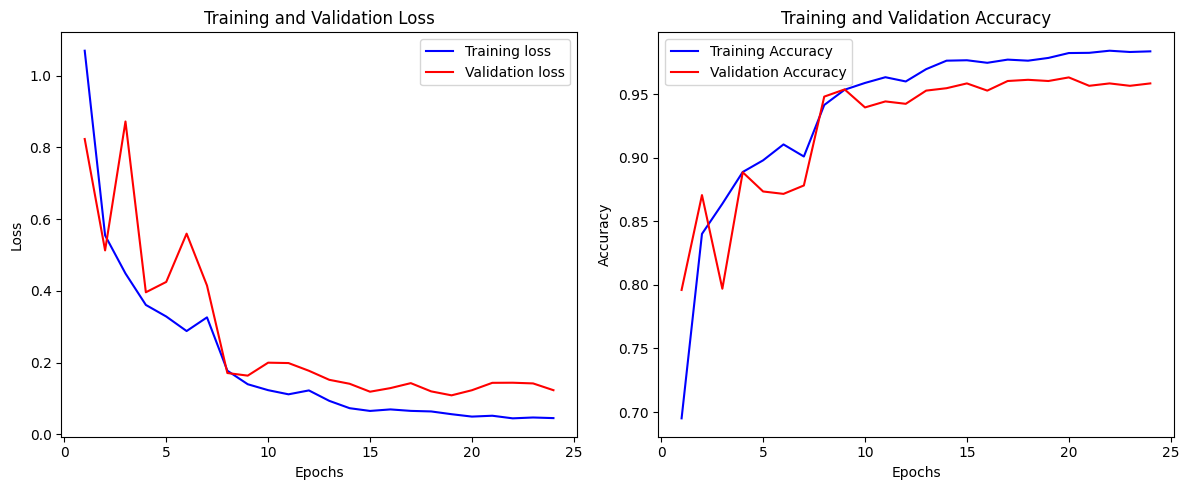

In [36]:
plot_history(history)

# Save Model

## Save class indices

In [18]:
np.save('class_indices.npy',  train_generator.class_indices)

## Save as h5 model

In [37]:
model.save('inception_v1.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Save as saved model

In [38]:
saved_model_dir = 'saved_model_inception_v1'
tf.saved_model.save(model, saved_model_dir)

## Convert to JSON

In [39]:
!pip install tensorflowjs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


INFO: pip is looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 92.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: tensorstore
    Found existing installation: tensorstore 0.1.60
    Uninstalling tensorstore-0.1.60:
      

In [1]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model --signature_name=serving_default --saved_model_tags=serve /kaggle/working/saved_model_inception_v1 tfjs_model

2024-06-17 06:58:18.792228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 06:58:18.792296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 06:58:18.794037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import shutil

# shutil.make_archive(saved_model_dir, 'zip', saved_model_dir)
shutil.make_archive('/kaggle/working/tfjs_inception_v1', 'zip', 'tfjs_model')

'/kaggle/working/tfjs_inception_v1.zip'

## Convert to Tflite

In [4]:
!pip install tensorflow=="2.13.0"

  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached keras-2.13.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached tensorboard-2.13.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━

In [5]:
pip install tflite-support

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 29.1 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
class_indices = np.load('class_indices.npy', allow_pickle=True).item()

with open('class_labels.txt', 'w') as f:
    for class_name in class_indices:
        f.write(f"{class_name}\n")

In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Mengonversi model ke format TFLite
tflite_model = converter.convert()

# Save the model to a file
with open('inception_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Create metadata for the mobilenet_v3
writer = image_classifier.MetadataWriter.create_for_inference(
    writer_utils.load_file('inception_model.tflite'),
    input_norm_mean=[0],  # Mean value for normalization (0 means no normalization)
    input_norm_std=[1],   # Standard deviation for normalization (1 means no normalization)
    label_file_paths=['class_labels.txt']
)

# Populate the metadata into the mobilenet_v3 file
writer_utils.save_file(writer.populate(), 'inception_v1_with_metadata.tflite')


# Make Prediction¶

In [21]:
model = load_model(f'{model_name}.h5')

In [22]:
class_indices = np.load('class_indices.npy', allow_pickle=True).item()
class_labels = {v: k for k, v in class_indices.items()}
class_labels

{0: 'adas',
 1: 'andaliman',
 2: 'asam jawa',
 3: 'bawang bombai',
 4: 'bawang merah',
 5: 'bawang putih',
 6: 'biji ketumbar',
 7: 'bukan rempah',
 8: 'bunga lawang',
 9: 'cengkeh',
 10: 'daun jeruk',
 11: 'daun kemangi',
 12: 'daun ketumbar',
 13: 'daun salam',
 14: 'jahe',
 15: 'jinten',
 16: 'kapulaga',
 17: 'kayu manis',
 18: 'kayu secang',
 19: 'kemiri',
 20: 'kemukus',
 21: 'kencur',
 22: 'kluwek',
 23: 'kunyit',
 24: 'lada',
 25: 'lengkuas',
 26: 'pala',
 27: 'saffron',
 28: 'serai',
 29: 'vanili',
 30: 'wijen'}

In [25]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array


# Load class indices
class_indices = np.load('class_indices.npy', allow_pickle=True).item()
class_labels = {v: k for k, v in class_indices.items()}

# Upload files
uploaded = files.upload()

# Create test folder if it doesn't exist
if not os.path.exists('test'):
    os.makedirs('test')

for fn in uploaded.keys():
    # Move the uploaded file to the test folder
    os.rename(fn, os.path.join('test', fn))
    path = os.path.join('test', fn)

    # Predicting images
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    predictions = model.predict(x)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]

    # Menampilkan hasil prediksi
    print(f'Gambar {fn} diprediksi sebagai kelas: {predicted_class_label} dengan probabilitas: {predictions[0][predicted_class_index]}')

ModuleNotFoundError: No module named 'google.colab'